# Slope-alignment

Parameterize and explore the dependence of mean square slope on wind-wave alignment.

In [56]:
from typing import List, Tuple

import colorcet
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from src import stats, plotting
from configure import read_stored_variable

## Setup

Run the previous notebook and read stored variables.

In [ ]:
%%capture
%run 'nb6-slope-secondary-dependence.ipynb'
%run -i configure.py

In [58]:
microswift_df = read_stored_variable('microswift_df')
spotter_df = read_stored_variable('spotter_df')
coamps_ds = read_stored_variable('coamps_ds')
time_slice = read_stored_variable('time_slice')
tanh_fit = read_stored_variable('tanh_fit')
ndbc_ds = read_stored_variable('ndbc_ds')

plotting.configure_figures()

## Wind-wave alignment parameterization

Concatenate Spotter and microSWIFT data into a single DataFrame for fitting.

In [59]:
fit_columns = [
   'wind_speed',
   'mean_square_slope_intrinsic',
   'mean_square_slope_observed',
   'mean_square_slope_observed_deep_limit',
   'mean_square_slope_intrinsic_residual',
   'mean_square_slope_intrinsic_down_wind',
   'mean_square_slope_intrinsic_cross_wind',
   'mean_square_slope_intrinsic_ratio',
   'mean_wind_wave_alignment_cat',
   'mean_wind_wave_alignment_int',
]
spotter_fit_data = (spotter_df[fit_columns]
                    .dropna()
                    .query('wind_speed > 3')
                    .sort_values(by='wind_speed', axis=0))

microswift_fit_data = (microswift_df[fit_columns]
                       .dropna()
                       .query('wind_speed > 3')
                       .sort_values(by='wind_speed', axis=0))

fit_df = (pd.concat((spotter_fit_data, microswift_fit_data))
          .sort_values(by='wind_speed', axis=0))

is_aligned = fit_df['mean_wind_wave_alignment_cat'] == "aligned"
is_crossing = fit_df['mean_wind_wave_alignment_cat'] == "crossing"


Since there are only $n = 1$ observations in the opposing category, drop this category.

In [60]:
is_opposing = fit_df['mean_wind_wave_alignment_cat'] == "opposing"
fit_df = fit_df.loc[~is_opposing]

In [61]:
def perform_fit(
    fit_dict: dict,
    fit_df: pd.DataFrame,
    fit_col: str,
    x_cols: List[str],
) -> Tuple[pd.Series, pd.Series]:
    """ Fit the data in `fit_df` to the function specified in `fit_dict`. """
    # Fit function using nonlinear least squares.
    fit_dict['popt'], fit_dict['pcov'] = curve_fit(
        fit_dict['fun'],
        xdata=fit_df[x_cols].to_numpy().T,
        ydata=fit_df[fit_col],
        p0=fit_dict['p0'],  # initial parameter guesses
    )

    # Approximate parameter confidence intervals using the standard deviation.
    n = len(fit_df[fit_col])  # number of data points
    fit_dict['perr'], fit_dict['t_value'], fit_dict['popt_upper'], fit_dict['popt_lower'] = stats.parameter_confidence_intervals(
        popt=fit_dict['popt'],
        pcov=fit_dict['pcov'],
        n=n,
        alpha=0.05,  # 95% confidence interval
    )

    # Calculate the RMSE.
    fitted_values = fit_dict['fun'](fit_df[x_cols].to_numpy().T, *fit_dict['popt'])
    fitted_values = pd.Series(fitted_values, index=fit_df.index)
    fit_dict['rmse'] = stats.root_mean_square_error(
        y=fit_df[fit_col],
        y_hat=fitted_values
    )

    # Calculate residuals
    residuals =  fit_df[fit_col] - fitted_values

    return fitted_values, residuals


def plot_fit(
    ax: mpl.axes.Axes,
    fit_df: pd.DataFrame,
    fit_col: str,
    x_col: str = 'wind_speed',
    y_col: str = 'mean_square_slope_intrinsic',
    c_col: str = 'mean_wind_wave_alignment_int',
    scatter_kwargs=None,
    line_plot_kwargs=None,
) -> None:
    """ Plot the fit and underlying data in`fit_df`. """
    if scatter_kwargs is None:
        scatter_kwargs = {}
    if line_plot_kwargs is None:
        line_plot_kwargs = {}

    ax.scatter(
        x=fit_df[x_col],
        y=fit_df[y_col],
        c=fit_df[c_col],
        marker='o',
        **scatter_kwargs,
    )

    ax.plot(
        fit_df[x_col],
        fit_df[fit_col],
        **line_plot_kwargs,
    )

### Individual fits

Separate the data into crossing and aligned populations and fit each category separately using the tanh expression (previously fit to the overall dataset).

In [62]:
# Use prior fit with prior parameters as initial guesses.
aligned_fit = {
     'fun': tanh_fit['fun'],
     'p0': tanh_fit['popt'],
     'vars': tanh_fit['vars'],
}
crossing_fit = {
     'fun': tanh_fit['fun'],
     'p0': tanh_fit['popt'],
     'vars': tanh_fit['vars'],
}

fit_df.loc[is_crossing, 'crossing_fit'], fit_df.loc[is_crossing, 'crossing_fit_residuals'] \
    = perform_fit(fit_dict=crossing_fit,
                  fit_df=fit_df.loc[is_crossing, :],
                  fit_col='mean_square_slope_intrinsic',
                  x_cols='wind_speed')

fit_df.loc[is_aligned, 'aligned_fit'], fit_df.loc[is_aligned, 'aligned_fit_residuals'] \
    = perform_fit(fit_dict=aligned_fit,
                  fit_df=fit_df.loc[is_aligned, :],
                  fit_col='mean_square_slope_intrinsic',
                  x_cols='wind_speed')



Plot the fits.

Text(0, 0.5, 'mean square slope (-)')

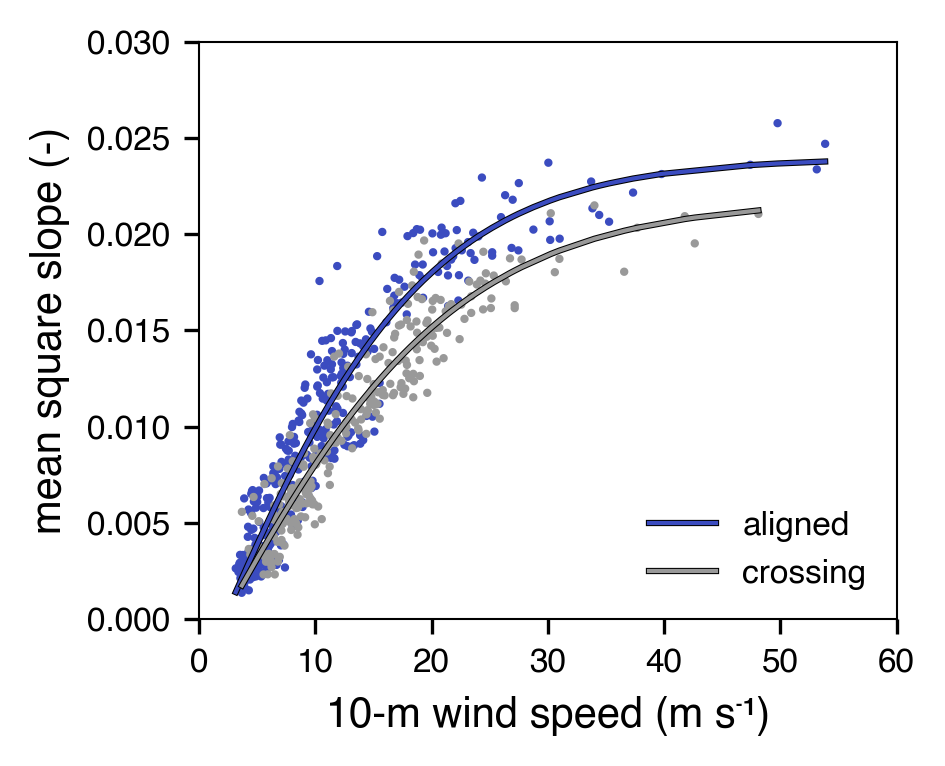

In [63]:
FIGURE_SIZE = (3, 2.5)

fig, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)

plot_fit(
    ax,
    fit_df.loc[is_aligned],
    fit_col='aligned_fit',
    scatter_kwargs=dict(**plotting.wind_wave_alignment_cat_plot_kwargs, s=1),
    line_plot_kwargs=dict(
        color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](0),
        path_effects=[pe.Stroke(linewidth=1.5, foreground='k', capstyle="projecting"), pe.Normal()],
        label='aligned',
        linewidth=1,
    ),
)

plot_fit(
    ax,
    fit_df.loc[is_crossing],
    fit_col='crossing_fit',
    scatter_kwargs=dict(**plotting.wind_wave_alignment_cat_plot_kwargs, s=1),
    line_plot_kwargs=dict(
        color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](1),
        path_effects=[pe.Stroke(linewidth=1.5, foreground='k', capstyle="projecting"), pe.Normal()],
        label='crossing',
        linewidth=1,
    ),
)

ax.legend(loc='lower right', frameon=False, fontsize=plotting.small_font_size)
ax.set_ylim((0,0.03))
ax.set_xlim((0, 60))
ax.set_xlabel('10-m wind speed (m s\u207B\u00B9)')
ax.set_ylabel('mean square slope (-)')

Compare the parameters $a$, $b$, $c$, and $d$ across fits to the aligned, crossing, and combined populations.

In [64]:
print('aligned fit:')
stats.print_fit_parameters(aligned_fit)

print('\ncrossing fit:')
stats.print_fit_parameters(crossing_fit)


aligned fit:
a: 0.02695 +/- 0.00099
b: 0.05208 +/- 0.00449
c: -0.00298 +/- 0.00069

crossing fit:
a: 0.02409 +/- 0.00119
b: 0.04574 +/- 0.00577
c: -0.00227 +/- 0.00097


In [65]:
print(f'a (crossing): {crossing_fit['popt'][0]: 0.5f}')
print(f'Lower bound of 95% CI on a: {crossing_fit['popt_lower'][0]: 0.4f}')
print(f'Upper bound of 95% CI on a: {crossing_fit['popt_upper'][0]: 0.4f}')

a (crossing):  0.02409
Lower bound of 95% CI on a:  0.0229
Upper bound of 95% CI on a:  0.0253


In [66]:
print(f'a (aligned): {aligned_fit['popt'][0]: 0.5f}')
print(f'Lower bound of 95% CI on a: {aligned_fit['popt_lower'][0]: 0.4f}')
print(f'Upper bound of 95% CI on a: {aligned_fit['popt_upper'][0]: 0.4f}')

a (aligned):  0.02695
Lower bound of 95% CI on a:  0.0260
Upper bound of 95% CI on a:  0.0279


In [67]:
print(f'b (crossing): {crossing_fit['popt'][1]: 0.5f}')
print(f'Lower bound of 95% CI on b: {crossing_fit['popt_lower'][1]: 0.4f}')
print(f'Upper bound of 95% CI on b: {crossing_fit['popt_upper'][1]: 0.4f}')

b (crossing):  0.04574
Lower bound of 95% CI on b:  0.0400
Upper bound of 95% CI on b:  0.0515


In [68]:
print(f'b (aligned): {aligned_fit['popt'][1]: 0.5f}')
print(f'Lower bound of 95% CI on b: {aligned_fit['popt_lower'][1]: 0.4f}')
print(f'Upper bound of 95% CI on b: {aligned_fit['popt_upper'][1]: 0.4f}')

b (aligned):  0.05208
Lower bound of 95% CI on b:  0.0476
Upper bound of 95% CI on b:  0.0566


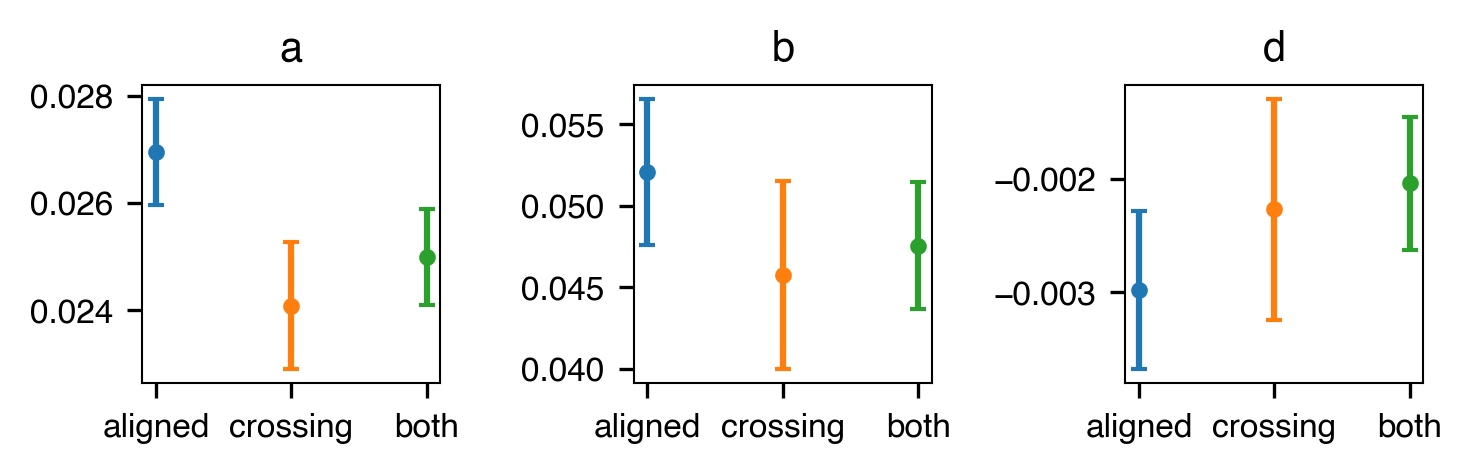

In [69]:
FIGURE_SIZE = (5, 2)

fig, axes = plt.subplots(1, 3, figsize=FIGURE_SIZE, sharex=True)
param_labels = ['a', 'b', 'd']
for param_index, ax in zip(range(len(param_labels)), axes.ravel()):
    ax.errorbar(
        x='aligned',
        y=aligned_fit['popt'][param_index],
        yerr=aligned_fit['popt_upper'][param_index] - aligned_fit['popt'][param_index],
        marker='o',
        capsize=2
    )
    ax.errorbar(
        x='crossing',
        y=crossing_fit['popt'][param_index],
        yerr=crossing_fit['popt_upper'][param_index] - crossing_fit['popt'][param_index],
        marker='o',
        capsize=2,
    )
    ax.errorbar(
        x='both',
        y=tanh_fit['popt'][param_index],
        yerr=tanh_fit['popt_upper'][param_index] - tanh_fit['popt'][param_index],
        marker='o',
        capsize=2,
    )
    ax.set_title(param_labels[param_index])
    plotting.set_square_aspect(ax)
fig.tight_layout()

This suggests parameter $a$ is unique to each category.  Parameters $b$ and $c$ are contained within confidence intervals of each category's fit.

### Multivariate fit

Treating wind-wave alignment as a categorical variable, a combined fit can be created where some parameters are shared and others are unique to each category. For example:
\begin{equation*}
    \mathrm{mss}(U_{10}, \Delta\theta)
    = A(\Delta\theta) \tanh b + c
\end{equation*}
with
\begin{equation*}
A(\Delta\theta) = a + a' \mathbf{1}_\mathrm{aligned}(\Delta\theta)
\end{equation*}
where $\mathbf{1}_\mathrm{aligned}(\Delta\theta)$ is an indicator function which evaluates to 1 if $\Delta\theta$ is categorized as "aligned" and evaluates to 0 if $\Delta\theta$ is  categorized "crossing" such that

\begin{equation*}
    \mathrm{mss}(U_{10}, \Delta\theta)
    = \begin{cases}
    (a + a')
    \tanh \left(
        b U_{10}
    \right)
    + c,
    & 0\degree \leq |\Delta\theta| \leq 45\degree \; (\mathrm{aligned}) \\
    a
    \tanh \left(
        b U_{10}
    \right)
     + c,
    & 45 \degree < |\Delta\theta| \leq 135\degree \; (\mathrm{crossing}) \\
    \textrm{not observed} & 135 \degree < |\Delta\theta| \leq 180\degree \; (\mathrm{opposing})
    \end{cases}
\end{equation*}

<!-- 
\begin{equation*}
    \mathrm{mss}(U_{10}, \Delta\theta)
    = \begin{cases}
    a \tanh \left(
        \left(
            b + b'
        \right) 
        U_{10}
    \right) 
    +
    \left(
            c + c'
    \right) 
    U_{10} + d, & 0\degree \leq |\Delta\theta| \leq 45\degree \; (\mathrm{aligned}) \\
    a \tanh \left(
        b U_{10}
    \right) + c U_{10} + d, & 45 \degree < |\Delta\theta| \leq 135\degree \; (\mathrm{crossing}) \\
    \textrm{not observed} & 135 \degree < |\Delta\theta| \leq 180\degree \; (\mathrm{opposing})
    \end{cases}
\end{equation*} -->

This allows parameter $b$ to be unique to each category (through $b'$).  We can also test an additional expression which use the same indicator function to enable variation in the linear $U_{10}$ multiplier term, $c$, and the offset term, $d$ (i.e., by using $c'$ and $d'$).

In [70]:
# Assign indicator values to each category.
fit_df.loc[is_aligned, ['alignment_indicator']] = 1
fit_df.loc[is_crossing, ['alignment_indicator']] = 0

Define three fits, each with a variable coefficient for aligned and crossing ($a$, $b$, and $c$).


In [71]:
# Use prior fit parameters to initialize the fits.
tanh_popt = tanh_fit['popt']

def mss_multivariate_fit_1(u, a, a_prime, b, c):
     """ tanh with a_prime. """
     u_10, alignment_indicator = u
     A = a + a_prime*alignment_indicator
     return A * np.tanh(b *u_10) + c
p0_fit_1 = [tanh_popt[0], 0, tanh_popt[1], tanh_popt[2]]
variable_names_fit_1 = ['a', 'a_prime', 'b', 'c']

def mss_multivariate_fit_2(u, a, b, b_prime, c):
     """ tanh with b_prime. """
     u_10, alignment_indicator = u
     B = b + b_prime*alignment_indicator
     return a * np.tanh(B *u_10) + c
p0_fit_2 = [tanh_popt[0], tanh_popt[1], 0, tanh_popt[2]]
variable_names_fit_2 = ['a', 'b', 'b_prime', 'c']

def mss_multivariate_fit_3(u, a, b, c, c_prime):
     """ tanh with c_prime. """
     u_10, alignment_indicator = u
     return a * np.tanh(b * u_10) +c + c_prime*alignment_indicator
p0_fit_3 = [tanh_popt[0], tanh_popt[1], tanh_popt[2], 0]
variable_names_fit_3 = ['a', 'b', 'c', 'c_prime']


In [72]:
multivariate_fit_dict = {
     'fit_1': {
          'fun': mss_multivariate_fit_1,
          'p0': p0_fit_1,
          'vars': variable_names_fit_1,
     },
     'fit_2': {
          'fun': mss_multivariate_fit_2,
          'p0': p0_fit_2,
          'vars': variable_names_fit_2,
     },
     'fit_3': {
          'fun': mss_multivariate_fit_3,
          'p0': p0_fit_3,
          'vars': variable_names_fit_3,
     },
}

x_cols = ['wind_speed', 'alignment_indicator']
for key, fit_dict in multivariate_fit_dict.items():
     fit_df.loc[:, key], fit_df.loc[:, key + '_residuals'] = perform_fit(
          fit_dict=fit_dict,
          fit_df=fit_df,
          fit_col='mean_square_slope_intrinsic',
          x_cols=x_cols
     )
     print(f'{key} RMSE: {fit_dict['rmse']:.6f}')

fit_1 RMSE: 0.001757
fit_2 RMSE: 0.001771
fit_3 RMSE: 0.001790


Rename the best fit columns (to remove the fit number) and assign them to a new Dataframe, `fit_by_category_df`.

In [73]:
best_fit = 'fit_1'
best_fit_columns = fit_df.filter(like=best_fit).columns.to_list()
fit_by_category_df = fit_df[fit_columns + ['alignment_indicator'] + best_fit_columns].rename(
    columns={col: col.replace(best_fit, 'fit') for col in best_fit_columns}
)

Fit 1, the tanh fit with $a'$ has the lowest RMSE.

Print 95% confidence intervals on the best fit parameters.

In [74]:
# Parameters +/- 95% confidence intervals.
stats.print_fit_parameters(multivariate_fit_dict[best_fit])

a: 0.02356 +/- 0.00072
a_prime: 0.00368 +/- 0.00052
b: 0.05020 +/- 0.00350
c: -0.00279 +/- 0.00056


If this fit statistically significant across aligned and crossing categories, the confidence interval on $b'$ and $c'$ parameters should **not** contain zero.

In [75]:
i = 1
print(f'a_prime: {multivariate_fit_dict[best_fit]['popt'][i]: 0.5f}')
print(f'Lower bound of 95% CI on a_prime: {multivariate_fit_dict[best_fit]['popt_lower'][i]: 0.4f}')
print(f'Upper bound of 95% CI on a_prime: {multivariate_fit_dict[best_fit]['popt_upper'][i]: 0.4f}')

a_prime:  0.00368
Lower bound of 95% CI on a_prime:  0.0032
Upper bound of 95% CI on a_prime:  0.0042


Only one observation is in the ``opposing'' wind-wave alignment category such that the behavior of mss within this category is unknown.

Plot the multivariate fit.

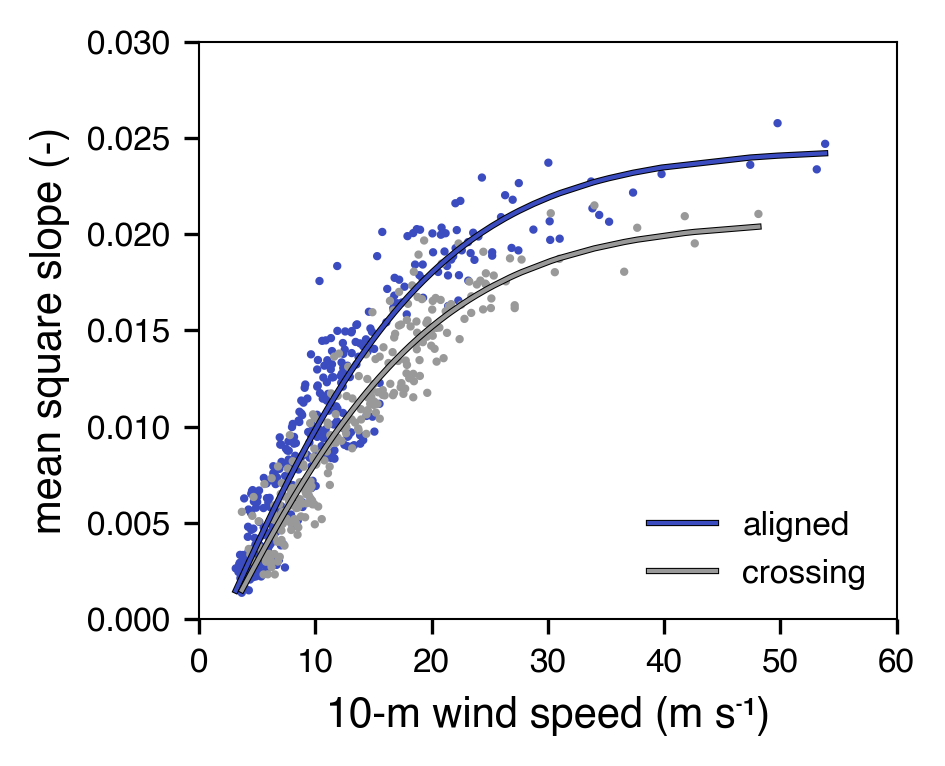

In [76]:
FIGURE_SIZE = (3, 2.5)


def plot_multivariate_intrinsic_mss_fit(ax, fit_df):
    fit_col = 'fit'
    y_col = 'mean_square_slope_intrinsic'
    is_aligned = fit_df['mean_wind_wave_alignment_cat'] == "aligned"
    is_crossing = fit_df['mean_wind_wave_alignment_cat'] == "crossing"

    plot_fit(
        ax,
        fit_df.loc[is_aligned],
        fit_col=fit_col,
        y_col=y_col,
        scatter_kwargs=dict(**plotting.wind_wave_alignment_cat_plot_kwargs, s=1),
        line_plot_kwargs=dict(
            color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](0),
            path_effects=[pe.Stroke(linewidth=1.5, foreground='k', capstyle="projecting"), pe.Normal()],
            label='aligned',
            linewidth=1,
        ),
    )
    plot_fit(
        ax,
        fit_df.loc[is_crossing],
        fit_col=fit_col,
        y_col=y_col,
        scatter_kwargs=dict(**plotting.wind_wave_alignment_cat_plot_kwargs, s=1),
        line_plot_kwargs=dict(
            color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](1),
            path_effects=[pe.Stroke(linewidth=1.5, foreground='k'), pe.Normal()],
            label='crossing',
            linewidth=1,
        ),
    )
    ax.legend(loc='lower right', frameon=False, fontsize=plotting.small_font_size)
    ax.set_ylim((0,0.03))
    ax.set_xlim((0, 60))
    ax.set_xlabel('10-m wind speed (m s\u207B\u00B9)')
    ax.set_ylabel('mean square slope (-)')

fig, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)
plot_multivariate_intrinsic_mss_fit(ax, fit_by_category_df)


Evaluate the fit at various wind speeds.

In [77]:
x_cols = ['wind_speed', 'alignment_indicator']
aligned = multivariate_fit_dict[best_fit]['fun'](fit_df.loc[is_aligned][x_cols].to_numpy().T, *multivariate_fit_dict[best_fit]['popt'])
crossing = multivariate_fit_dict[best_fit]['fun'](fit_df.loc[is_crossing][x_cols].to_numpy().T, *multivariate_fit_dict[best_fit]['popt'])

wind_speeds = np.arange(5, 60, 5)
aligned_indicator = np.ones(wind_speeds.shape)
crossing_indicator = np.zeros(wind_speeds.shape)
aligned_fit_values = multivariate_fit_dict[best_fit]['fun'](np.array([wind_speeds, aligned_indicator]), *multivariate_fit_dict[best_fit]['popt'])
crossing_fit_values = multivariate_fit_dict[best_fit]['fun'](np.array([wind_speeds, crossing_indicator]), *multivariate_fit_dict[best_fit]['popt'])

In [78]:
percent_differences = stats.percent_difference(aligned_fit_values, crossing_fit_values)
print(f'Percent difference at 10 m/s: {percent_differences[wind_speeds == 10].squeeze():0.1f}%')
print(f'Percent difference at 15 m/s: {percent_differences[wind_speeds == 15].squeeze():0.1f}%')
print(f'Percent difference at 20 m/s: {percent_differences[wind_speeds == 20].squeeze():0.1f}%')
print(f'Percent difference at 30 m/s: {percent_differences[wind_speeds == 30].squeeze():0.1f}%')
print(f'Percent difference at 40 m/s: {percent_differences[wind_speeds == 40].squeeze():0.1f}%')

Percent difference at 10 m/s: 19.0%
Percent difference at 15 m/s: 17.5%
Percent difference at 20 m/s: 16.9%
Percent difference at 30 m/s: 16.5%
Percent difference at 40 m/s: 16.4%


### Fit to observed mean square slopes

Individual fits to observed data.

In [79]:
# Use prior fit with prior parameters as initial guesses.
observed_aligned_fit = {
     'fun': tanh_fit['fun'],
     'p0': tanh_fit['popt'],
     'vars': tanh_fit['vars'],
}
observed_crossing_fit = {
     'fun': tanh_fit['fun'],
     'p0': tanh_fit['popt'],
     'vars': tanh_fit['vars'],
}

fit_df.loc[is_crossing, 'observed_crossing_fit'], fit_df.loc[is_crossing, 'observed_crossing_fit_residuals'] \
    = perform_fit(fit_dict=observed_crossing_fit,
                  fit_df=fit_df.loc[is_crossing, :],
                  fit_col='mean_square_slope_observed',
                  x_cols='wind_speed')

fit_df.loc[is_aligned, 'observed_aligned_fit'], fit_df.loc[is_aligned, 'observed_aligned_fit_residuals'] \
    = perform_fit(fit_dict=observed_aligned_fit,
                  fit_df=fit_df.loc[is_aligned, :],
                  fit_col='mean_square_slope_observed',
                  x_cols='wind_speed')



Plot the fits.

Text(0, 0.5, 'mean square slope (-)')

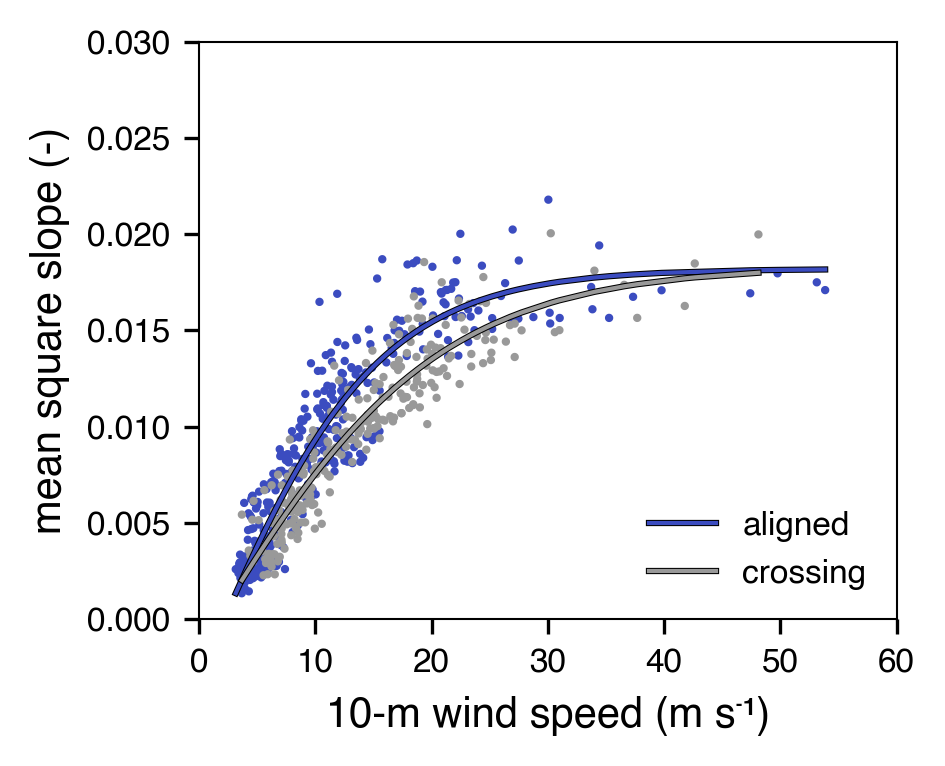

In [80]:
FIGURE_SIZE = (3, 2.5)

fig, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)
y_col = 'mean_square_slope_observed'

plot_fit(
    ax,
    fit_df.loc[is_aligned],
    fit_col='observed_aligned_fit',
    y_col=y_col,
    scatter_kwargs=dict(**plotting.wind_wave_alignment_cat_plot_kwargs, s=1),
    line_plot_kwargs=dict(
        color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](0),
        path_effects=[pe.Stroke(linewidth=1.5, foreground='k', capstyle="projecting"), pe.Normal()],
        label='aligned',
        linewidth=1,
    ),
)

plot_fit(
    ax,
    fit_df.loc[is_crossing],
    fit_col='observed_crossing_fit',
    y_col=y_col,
    scatter_kwargs=dict(**plotting.wind_wave_alignment_cat_plot_kwargs, s=1),
    line_plot_kwargs=dict(
        color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](1),
        path_effects=[pe.Stroke(linewidth=1.5, foreground='k', capstyle="projecting"), pe.Normal()],
        label='crossing',
        linewidth=1,
    ),
)

ax.legend(loc='lower right', frameon=False, fontsize=plotting.small_font_size)
ax.set_ylim((0,0.03))
ax.set_xlim((0, 60))
ax.set_xlabel('10-m wind speed (m s\u207B\u00B9)')
ax.set_ylabel('mean square slope (-)')

Compare the parameters $a$, $b$, and $c$ across fits to the aligned and crossing populations.

In [81]:
print('aligned fit:')
stats.print_fit_parameters(observed_aligned_fit)

print('\ncrossing fit:')
stats.print_fit_parameters(observed_crossing_fit)


aligned fit:
a: 0.02125 +/- 0.00080
b: 0.06661 +/- 0.00612
c: -0.00305 +/- 0.00080

crossing fit:
a: 0.01989 +/- 0.00102
b: 0.04949 +/- 0.00687
c: -0.00156 +/- 0.00100


In [82]:
print(f'a (crossing): {observed_crossing_fit['popt'][0]: 0.5f}')
print(f'Lower bound of 95% CI on a: {observed_crossing_fit['popt_lower'][0]: 0.4f}')
print(f'Upper bound of 95% CI on a: {observed_crossing_fit['popt_upper'][0]: 0.4f}')

a (crossing):  0.01989
Lower bound of 95% CI on a:  0.0189
Upper bound of 95% CI on a:  0.0209


In [83]:
print(f'a (crossing): {observed_aligned_fit['popt'][0]: 0.5f}')
print(f'Lower bound of 95% CI on a: {observed_aligned_fit['popt_lower'][0]: 0.4f}')
print(f'Upper bound of 95% CI on a: {observed_aligned_fit['popt_upper'][0]: 0.4f}')

a (crossing):  0.02125
Lower bound of 95% CI on a:  0.0205
Upper bound of 95% CI on a:  0.0221


In [84]:
print(f'b (crossing): {observed_crossing_fit['popt'][1]: 0.5f}')
print(f'Lower bound of 95% CI on b: {observed_crossing_fit['popt_lower'][1]: 0.4f}')
print(f'Upper bound of 95% CI on b: {observed_crossing_fit['popt_upper'][1]: 0.4f}')

b (crossing):  0.04949
Lower bound of 95% CI on b:  0.0426
Upper bound of 95% CI on b:  0.0564


In [85]:
print(f'b (aligned): {observed_aligned_fit['popt'][1]: 0.5f}')
print(f'Lower bound of 95% CI on b: {observed_aligned_fit['popt_lower'][1]: 0.4f}')
print(f'Upper bound of 95% CI on b: {observed_aligned_fit['popt_upper'][1]: 0.4f}')

b (aligned):  0.06661
Lower bound of 95% CI on b:  0.0605
Upper bound of 95% CI on b:  0.0727


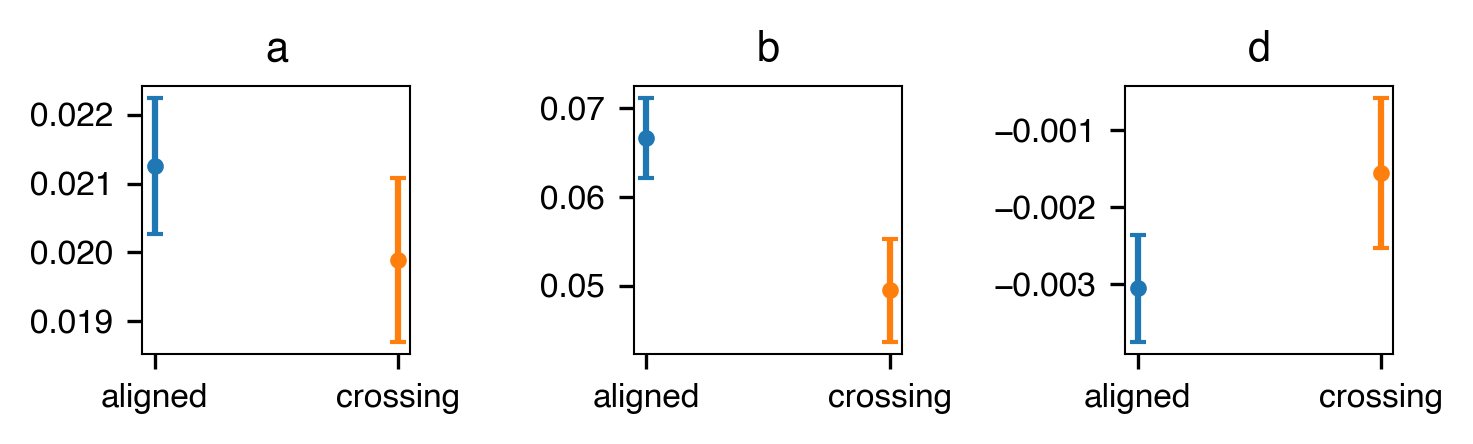

In [86]:
FIGURE_SIZE = (5, 2)

fig, axes = plt.subplots(1, 3, figsize=FIGURE_SIZE, sharex=True)
param_labels = ['a', 'b', 'd']
for param_index, ax in zip(range(len(param_labels)), axes.ravel()):
    ax.errorbar(
        x='aligned',
        y=observed_aligned_fit['popt'][param_index],
        yerr=aligned_fit['popt_upper'][param_index] - aligned_fit['popt'][param_index],
        marker='o',
        capsize=2
    )
    ax.errorbar(
        x='crossing',
        y=observed_crossing_fit['popt'][param_index],
        yerr=crossing_fit['popt_upper'][param_index] - crossing_fit['popt'][param_index],
        marker='o',
        capsize=2,
    )
    ax.set_title(param_labels[param_index])
    plotting.set_square_aspect(ax)
fig.tight_layout()

Fit the observed mean square slopes with a multivariate function.  Since observed mss has a strong saturation, the linear term is not needed (it may just cause overfitting).

In [87]:
observed_fit_dict = {
     'fit_1': {
          'fun': mss_multivariate_fit_1,
          'p0': p0_fit_1,
          'vars': variable_names_fit_1,
     },
     'fit_2': {
          'fun': mss_multivariate_fit_2,
          'p0': p0_fit_2,
          'vars': variable_names_fit_2,
     },
     'fit_3': {
          'fun': mss_multivariate_fit_3,
          'p0': p0_fit_3,
          'vars': variable_names_fit_3,
     },
}

x_cols = ['wind_speed', 'alignment_indicator']
for key, fit_dict in observed_fit_dict.items():
     fit_df.loc[:, 'observed_' + key], fit_df.loc[:, 'observed_' + key + '_residuals'] = perform_fit(
          fit_dict=fit_dict,
          fit_df=fit_df,
          fit_col='mean_square_slope_observed',
          x_cols=x_cols
     )
     print(f'{key} RMSE: {fit_dict['rmse']:.6f}')

fit_1 RMSE: 0.001694
fit_2 RMSE: 0.001684
fit_3 RMSE: 0.001699


In [88]:
best_observed_fit = 'fit_2'
new_cols = ['observed_fit', 'observed_fit_residuals']
best_fit_columns = fit_df.filter(like='observed_' + best_observed_fit).columns.to_list()
fit_by_category_df.loc[:, new_cols] = fit_df[best_fit_columns].rename(
    columns={col: col.replace('observed_' + best_observed_fit, 'observed_fit') for col in best_fit_columns}
)

Print the fit.

In [89]:
# Parameters +/- 95% confidence intervals.
stats.print_fit_parameters(observed_fit_dict[best_observed_fit])

a: 0.02077 +/- 0.00062
b: 0.05299 +/- 0.00401
b_prime: 0.01209 +/- 0.00231
c: -0.00261 +/- 0.00063


In [90]:
print(f'b_prime: {observed_fit_dict[best_observed_fit]['popt'][2]: 0.5f}')
print(f'Lower bound of 95% CI on b_prime: {observed_fit_dict[best_observed_fit]['popt_lower'][2]: 0.4f}')
print(f'Upper bound of 95% CI on b_prime: {observed_fit_dict[best_observed_fit]['popt_upper'][2]: 0.4f}')

b_prime:  0.01209
Lower bound of 95% CI on b_prime:  0.0098
Upper bound of 95% CI on b_prime:  0.0144


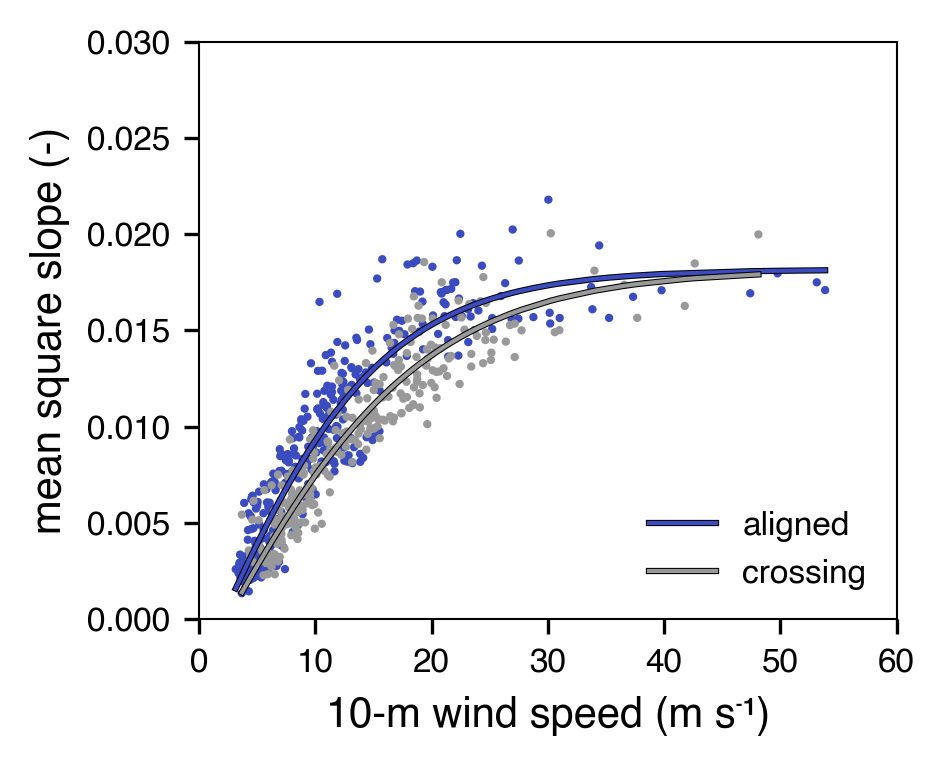

In [ ]:
FIGURE_SIZE = (3, 2.5)

def plot_multivariate_observed_mss_fit(ax, fit_df):
    fit_col = 'observed_fit'
    y_col = 'mean_square_slope_observed'
    is_aligned = fit_df['mean_wind_wave_alignment_cat'] == "aligned"
    is_crossing = fit_df['mean_wind_wave_alignment_cat'] == "crossing"

    plot_fit(
        ax,
        fit_df.loc[is_aligned],
        fit_col=fit_col,
        y_col=y_col,
        scatter_kwargs=dict(**plotting.wind_wave_alignment_cat_plot_kwargs, s=1),
        line_plot_kwargs=dict(
            color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](0),
            path_effects=[pe.Stroke(linewidth=1.5, foreground='k', capstyle="projecting"), pe.Normal()],
            label='aligned',
            linewidth=1,
        ),
    )
    plot_fit(
        ax,
        fit_df.loc[is_crossing],
        fit_col=fit_col,
        y_col=y_col,
        scatter_kwargs=dict(**plotting.wind_wave_alignment_cat_plot_kwargs, s=1),
        line_plot_kwargs=dict(
            color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](1),
            path_effects=[pe.Stroke(linewidth=1.5, foreground='k'), pe.Normal()],
            label='crossing',
            linewidth=1,
        ),
    )
    ax.legend(loc='lower right', frameon=False, fontsize=plotting.small_font_size)
    ax.set_ylim((0,0.03))
    ax.set_xlim((0, 60))
    ax.set_xlabel('10-m wind speed (m s\u207B\u00B9)')
    ax.set_ylabel('mean square slope (-)')

fig, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)
plot_multivariate_observed_mss_fit(ax, fit_by_category_df)

### Fit to down- and cross-wind mean square slopes

Fit the down- and cross-wind mean square slopes with the same multivariate function.

In [92]:
down_wind_fit_dict = {
    'fun': multivariate_fit_dict[best_fit]['fun'],
    'p0': multivariate_fit_dict[best_fit]['p0'],
    'vars': multivariate_fit_dict[best_fit]['vars'],
}

x_cols = ['wind_speed', 'alignment_indicator']
fit_by_category_df.loc[:, 'down_wind_fit'], fit_by_category_df.loc[:, 'down_wind_fit_residuals'] = perform_fit(
     fit_dict=down_wind_fit_dict,
     fit_df=fit_by_category_df,
     fit_col='mean_square_slope_intrinsic_down_wind',
     x_cols=x_cols
)

In [93]:
stats.print_fit_parameters(down_wind_fit_dict)

a: 0.01264 +/- 0.00039
a_prime: 0.00213 +/- 0.00028
b: 0.05166 +/- 0.00361
c: -0.00138 +/- 0.00032


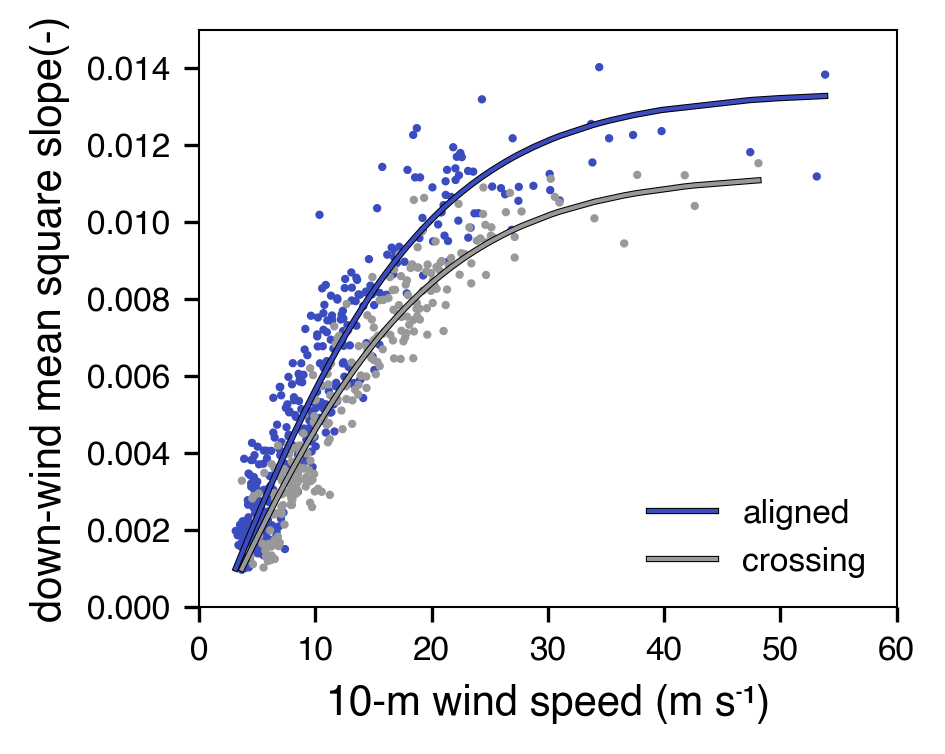

In [94]:
FIGURE_SIZE = (3, 2.5)

def plot_multivariate_mss_down_wind_fit(ax, fit_df):
    fit_col = 'down_wind_fit'
    y_col = 'mean_square_slope_intrinsic_down_wind'
    is_aligned = fit_df['mean_wind_wave_alignment_cat'] == "aligned"
    is_crossing = fit_df['mean_wind_wave_alignment_cat'] == "crossing"

    plot_fit(
        ax,
        fit_df.loc[is_aligned],
        fit_col=fit_col,
        y_col=y_col,
        scatter_kwargs=dict(**plotting.wind_wave_alignment_cat_plot_kwargs, s=1),
        line_plot_kwargs=dict(
            color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](0),
            path_effects=[pe.Stroke(linewidth=1.5, foreground='k', capstyle="projecting"), pe.Normal()],
            label='aligned',
            linewidth=1,
        ),
    )
    plot_fit(
        ax,
        fit_df.loc[is_crossing],
        fit_col=fit_col,
        y_col=y_col,
        scatter_kwargs=dict(**plotting.wind_wave_alignment_cat_plot_kwargs, s=1),
        line_plot_kwargs=dict(
            color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](1),
            path_effects=[pe.Stroke(linewidth=1.5, foreground='k'), pe.Normal()],
            label='crossing',
            linewidth=1,
        ),
    )
    ax.legend(loc='lower right', frameon=False, fontsize=plotting.small_font_size)
    ax.set_ylim((0,0.015))
    ax.set_xlim((0, 60))
    ax.set_xlabel('10-m wind speed (m s\u207B\u00B9)')
    ax.set_ylabel('down-wind mean square slope(-)')

fig, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)
plot_multivariate_mss_down_wind_fit(ax, fit_by_category_df)



In [95]:
cross_wind_fit = {
    'fun': multivariate_fit_dict[best_fit]['fun'],
    'p0': multivariate_fit_dict[best_fit]['p0'],
    'vars': multivariate_fit_dict[best_fit]['vars'],
}

x_cols = ['wind_speed', 'alignment_indicator']
fit_by_category_df.loc[:, 'cross_wind_fit'], fit_by_category_df.loc[:, 'cross_wind_fit_residuals'] = perform_fit(
    fit_dict=cross_wind_fit,
    fit_df=fit_by_category_df,
    fit_col='mean_square_slope_intrinsic_cross_wind',
    x_cols=x_cols
)

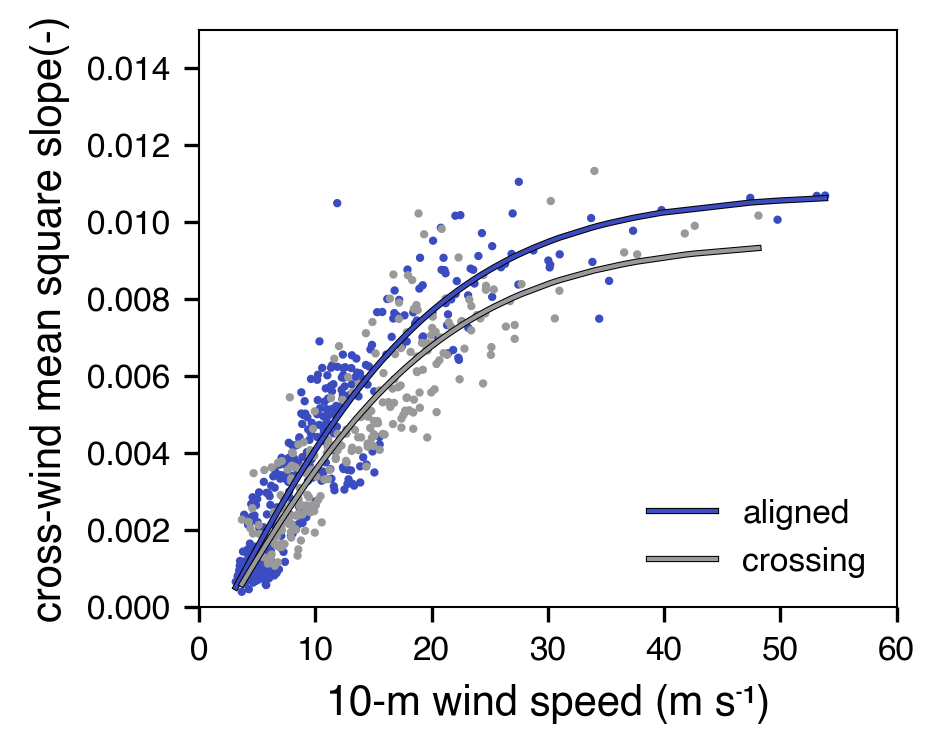

In [96]:
FIGURE_SIZE = (3, 2.5)
def plot_multivariate_mss_cross_wind_fit(ax, fit_df):
    fit_col = 'cross_wind_fit'
    y_col = 'mean_square_slope_intrinsic_cross_wind'
    is_aligned = fit_df['mean_wind_wave_alignment_cat'] == "aligned"
    is_crossing = fit_df['mean_wind_wave_alignment_cat'] == "crossing"

    plot_fit(
        ax,
        fit_df.loc[is_aligned],
        fit_col=fit_col,
        y_col=y_col,
        scatter_kwargs=dict(**plotting.wind_wave_alignment_cat_plot_kwargs, s=1),
        line_plot_kwargs=dict(
            color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](0),
            path_effects=[pe.Stroke(linewidth=1.5, foreground='k', capstyle="projecting"), pe.Normal()],
            label='aligned',
            linewidth=1,
        ),
    )
    plot_fit(
        ax,
        fit_df.loc[is_crossing],
        fit_col=fit_col,
        y_col=y_col,
        scatter_kwargs=dict(**plotting.wind_wave_alignment_cat_plot_kwargs, s=1),
        line_plot_kwargs=dict(
            color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](1),
            path_effects=[pe.Stroke(linewidth=1.5, foreground='k'), pe.Normal()],
            label='crossing',
            linewidth=1,
        ),
    )
    ax.legend(loc='lower right', frameon=False, fontsize=plotting.small_font_size)
    ax.set_ylim((0,0.015))
    ax.set_xlim((0, 60))
    ax.set_xlabel('10-m wind speed (m s\u207B\u00B9)')
    ax.set_ylabel('cross-wind mean square slope(-)')

fig, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)
plot_multivariate_mss_cross_wind_fit(ax, fit_by_category_df)

(The multivariate function may not be flexible enough to fit the cross-wind mss, however this fit is not provided in the publication.)

The ratio of cross-wind to down-wind mss is a measure of slope directionality.

In [97]:
fit_by_category_df['mean_square_slope_intrinsic_ratio'] \
    = fit_by_category_df['mean_square_slope_intrinsic_cross_wind'] / fit_by_category_df['mean_square_slope_intrinsic_down_wind']

The cross-wind mss to down-wind mss ratio can be sensitive at low wind speeds.  Instead of fitting the ratio, binned medians are used.

In [98]:
bins = np.array([2.5, 12.5, 22.5, 37.5, 52.5])

crossing_mss_ratio_bins = stats.binned_statistic_df(
    df=fit_by_category_df.loc[is_crossing],
    x='wind_speed',
    y='mean_square_slope_intrinsic_ratio',
    stat='median',
    bins=bins,
)
aligned_mss_ratio_bins = stats.binned_statistic_df(
    df=fit_by_category_df.loc[is_aligned],
    x='wind_speed',
    y='mean_square_slope_intrinsic_ratio',
    stat='median',
    bins=bins,
)

In [99]:
print(f'bins: {aligned_mss_ratio_bins['bin_centers']}')
print(f'bin medians (aligned): {aligned_mss_ratio_bins['bin_stat'].round(2)}')
print(f'bin stds (aligned): {aligned_mss_ratio_bins['bin_stds'].round(2)}')
print(f'bin medians (crossing): {crossing_mss_ratio_bins['bin_stat'].round(2)}')
print(f'bin stds (crossing): {crossing_mss_ratio_bins['bin_stds'].round(2)}')

bins: [ 7.5 17.5 30.  45. ]
bin medians (aligned): [0.66 0.74 0.8  0.83]
bin stds (aligned): [0.17 0.11 0.11 0.11]
bin medians (crossing): [0.79 0.75 0.8  0.87]
bin stds (crossing): [0.26 0.13 0.11 0.05]


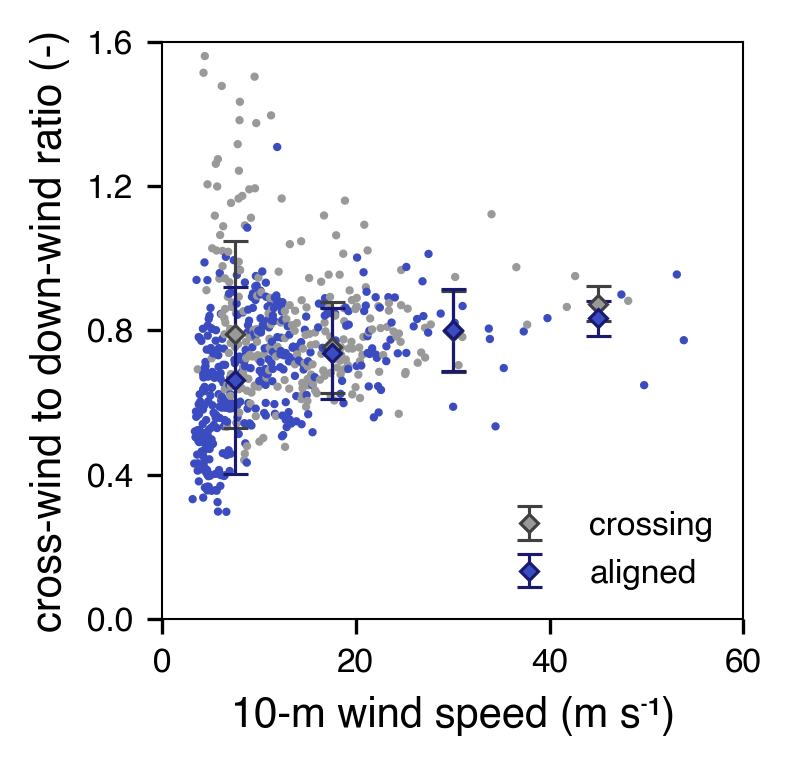

In [100]:
def plot_mss_ratio_bins(ax, crossing_mss_ratio_bins, aligned_mss_ratio_bins):
    errorbar_kwargs = dict(
        linestyle='none',
        markersize=3,
        marker='D',
        markeredgewidth=0.75,
        elinewidth=0.75,
        capsize=3,
    )
    ax.errorbar(
        x=crossing_mss_ratio_bins['bin_centers'],
        y=crossing_mss_ratio_bins['bin_stat'],
        yerr=crossing_mss_ratio_bins['bin_stds'],
        color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](1),
        label='crossing',
        ecolor=0.25 * np.array([1, 1, 1]),
        markeredgecolor=0.25 * np.array([1, 1, 1]),
        **errorbar_kwargs,
    )
    ax.errorbar(
        x=aligned_mss_ratio_bins['bin_centers'],
        y=aligned_mss_ratio_bins['bin_stat'],
        yerr=crossing_mss_ratio_bins['bin_stds'],
        color=plotting.wind_wave_alignment_cat_plot_kwargs['cmap'](0),
        ecolor='midnightblue',
        markeredgecolor='midnightblue',
        label='aligned',
        **errorbar_kwargs,
    )
    ax.legend(frameon=False, loc='lower right')
    ax.set_ylim((0, 1.6))
    ax.set_xlim((0, 60))
    ax.set_yticks(np.linspace(0, 1.6, 5))
    ax.set_xlabel('10-m wind speed (m s\u207B\u00B9)')
    ax.set_ylabel('cross-wind to down-wind ratio (-)')

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
ax.scatter(
    x=fit_df['wind_speed'],
    y=fit_df['mean_square_slope_intrinsic_ratio'],
    c=fit_df['mean_wind_wave_alignment_int'],
    s=1,
    **plotting.wind_wave_alignment_cat_plot_kwargs,
)
plot_mss_ratio_bins(ax, crossing_mss_ratio_bins, aligned_mss_ratio_bins)

## Mean square slope versus alignment

Plot mean square slope versus wind-wave alignment.  Color the scatter points to explore variation with 10-m wind speed and sensitivity to storm azimuth and distance.

In [101]:
def plot_mss_versus_alignment(
        ax,
        spotter_df=None,
        microswift_df=None,
        color_column_name=None,
        annotate=True,
        **plot_kwargs
    ):
    """ Plot mean square slope versus wind-wave alignment """
    if spotter_df is not None:
        sc = plotting.plot_drifter_scatter(
            spotter_df,
            ax,
            x_column_name='mean_wind_wave_alignment_abs',
            y_column_name='mean_square_slope_intrinsic',
            color_column_name=color_column_name,
            **plot_kwargs,
        )
    if microswift_df is not None:
        sc = plotting.plot_drifter_scatter(
            microswift_df,
            ax,
            x_column_name='mean_wind_wave_alignment_abs',
            y_column_name='mean_square_slope_intrinsic',
            color_column_name=color_column_name,
            **plot_kwargs,
        )

    if annotate:
        ax.annotate(
            '',
            xy=(0, 0.03*1.00), xycoords='data',
            xytext=(45, 0.03*1.00), textcoords='data',
            arrowprops={'arrowstyle': '<->', 'linewidth': 0.5})
        ax.annotate(
            'aligned',
            xy=(22.5, 0.03*1.00),
            xycoords='data',
            ha='center',
            va='bottom',
            fontsize=plotting.small_font_size,
        )
        ax.annotate(
            '',
            xy=(45, 0.03*1.00), xycoords='data',
            xytext=(135, 0.03*1.00), textcoords='data',
            arrowprops={'arrowstyle': '<->', 'linewidth': 0.5})
        ax.annotate(
            'crossing',
            xy=(90, 0.03*1.00),
            xycoords='data',
            ha='center',
            va='bottom',
            fontsize=plotting.small_font_size,
        )

    ax.set_xlim([0, 135])
    ax.set_ylim([0.0, 0.03])
    ax.set_xticks(np.linspace(0, 135, 4))
    ax.set_ylabel('mean square slope (-)')
    ax.set_xlabel('absolute wind-wave alignment (deg)')
    plotting.remove_top_and_right_spines(ax)

    return sc

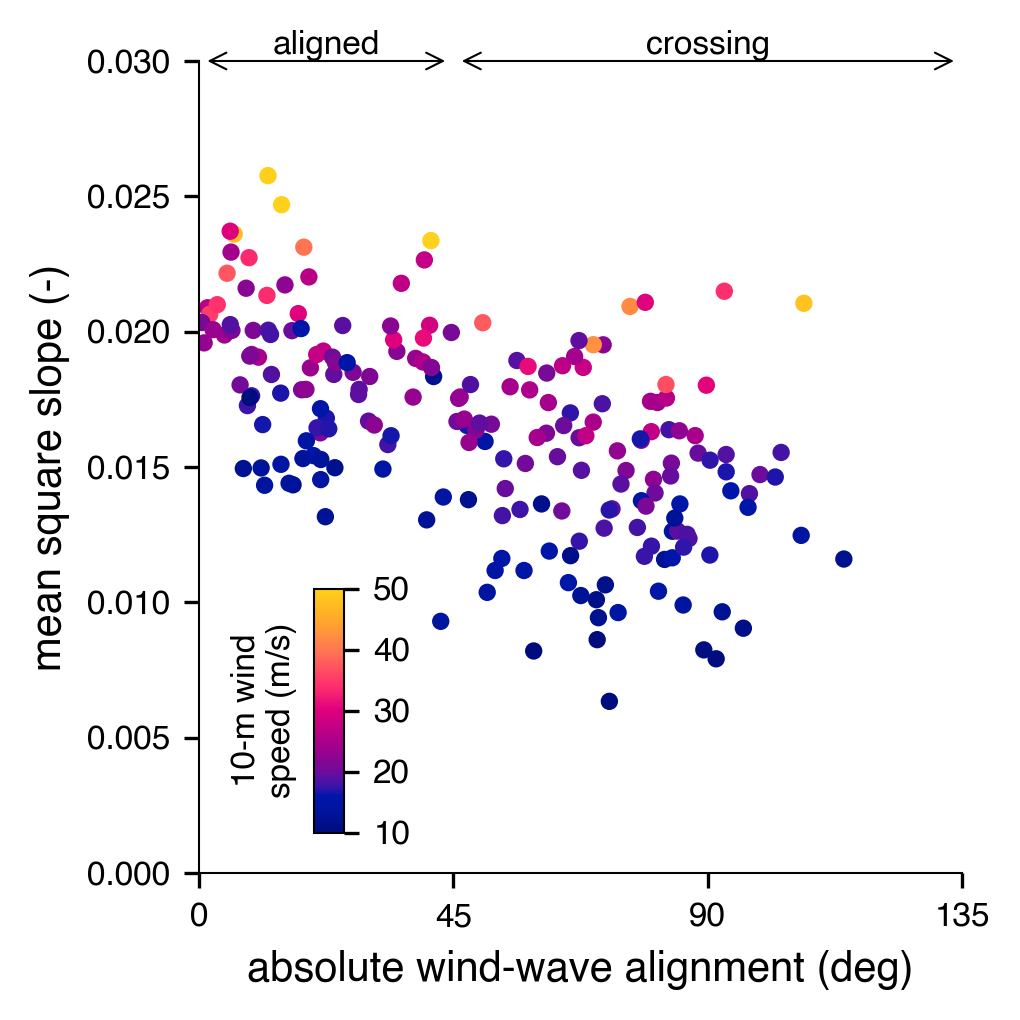

In [102]:
FIG_SIZE = (3.5, 3.5)


def plot_mss_versus_alignment_wind_speed(ax, **kwargs):

    color_column_name = 'wind_speed'
    cmap = plotting.wind_speed_plot_kwargs['cmap']
    norm = plotting.wind_speed_plot_kwargs['norm']

    sc = plot_mss_versus_alignment(
        ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        s=10,
        **kwargs
    )

    cbar, cax = plotting.create_inset_colorbar(
        sc,
        ax,
        bounds=[0.15, 0.05, 0.04, 0.3],
        orientation='vertical'
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_ticks(np.linspace(norm.vmin, norm.vmax, 5))
    cbar.set_label('10-m wind\nspeed (m/s)',
                    fontsize=plotting.small_font_size)


fig, ax = plt.subplots(figsize=FIG_SIZE)
plot_mss_versus_alignment_wind_speed(
    ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
)
fig.tight_layout()

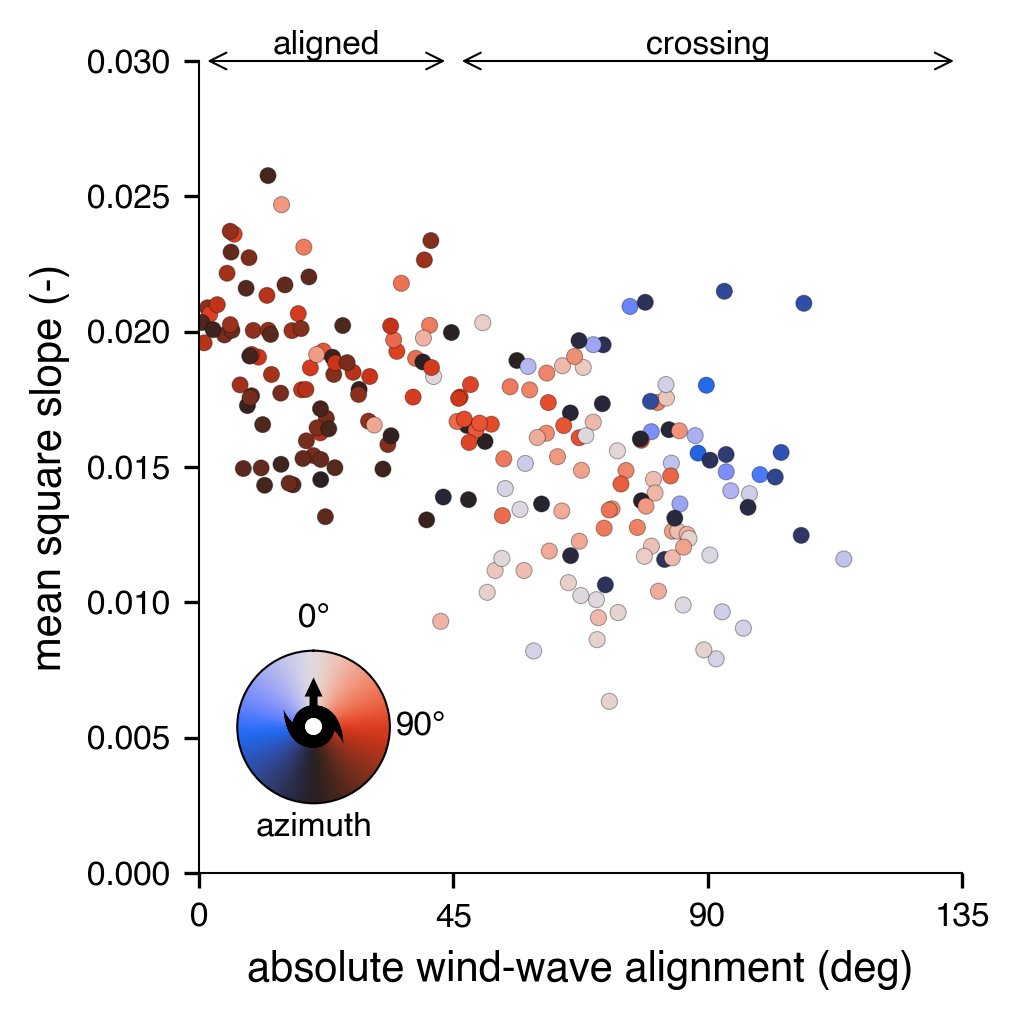

In [103]:
FIG_SIZE = (3.5, 3.5)


def plot_mss_versus_alignment_azimuth(ax, **kwargs):

    color_column_name = 'storm_frame_azimuth'
    cmap = colorcet.cm.cyclic_wrkbw_10_90_c43
    norm = mpl.colors.Normalize(vmin=0, vmax=360)

    sc = plot_mss_versus_alignment(
        ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        s=15,
        linewidth=0.25,
        edgecolors=[0, 0, 0, 0.35],
        **kwargs
    )

    # cylic legend
    legend_location = [0.05, 0.08 ,0.2, 0.2]
    ax2 = ax.inset_axes(legend_location, projection='polar')
    azimuths = np.arange(0, 361, 1)
    zeniths = np.linspace(0.2, 1, 10)
    values = azimuths * np.ones((len(zeniths), len(azimuths)))
    ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap=cmap)
    ax2.set_yticks([])
    ax2.set_theta_zero_location('N')
    ax2.set_theta_direction(-1)
    ax2.xaxis.grid(False)
    ax2.tick_params(pad=-3,labelsize=plotting.small_font_size)
    ax2.set_ylim([0, 1])
    ax2.set_xticks([0, np.pi/2, np.pi])
    ax2.set_xticks([0, np.pi/2])
    plotting.plot_hurricane_symbol(
        ax2,
        xy=(0, 0),
        annotation_bbox_kwargs={'zorder': 5}
    )
    ax2.set_xlabel('azimuth', fontsize=plotting.small_font_size, labelpad=2)

    # arrow
    ax3 = ax.inset_axes(legend_location)
    arrow_kwargs = dict(  #TODO: used for RMW norm
        dx=0,
        dy=0.2,
        width=0.05,
        color='k',
        lw=1,
        head_length=0.15,
    )
    ax3.arrow(0, 0.2, **arrow_kwargs)
    ax3.set_axis_off()
    ax3.set_ylim([-1, 1])
    ax3.set_xlim([-1, 1])


fig, ax = plt.subplots(figsize=FIG_SIZE)
plot_mss_versus_alignment_azimuth(
    ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
)
fig.tight_layout()

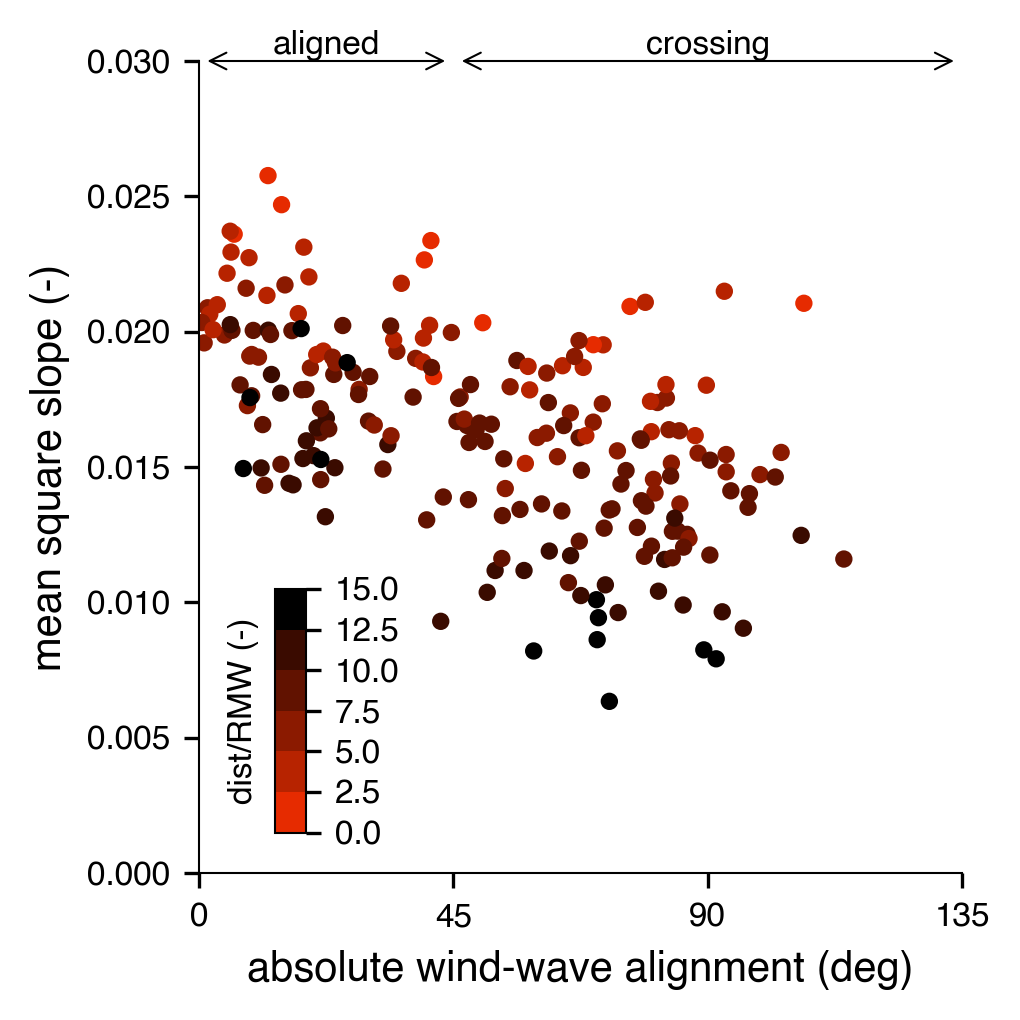

In [104]:
FIG_SIZE = (3.5, 3.5)


def plot_mss_versus_alignment_distance(ax, **kwargs):

    color_column_name = 'storm_distance_xy_normalized_magnitude'
    cmap = colorcet.cm.kr_r
    bins = np.linspace(0, 15, 7)
    norm = mpl.colors.BoundaryNorm(bins, 256)


    sc = plot_mss_versus_alignment(
        ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        s=10,
        **kwargs
    )

    cbar, cax = plotting.create_inset_colorbar(
        sc,
        ax,
        bounds=[0.10, 0.05, 0.04, 0.3],
        orientation='vertical'
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_label(
        'd/RMW (-)',
        fontsize=plotting.small_font_size,
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_label('dist/RMW (-)',
                    fontsize=plotting.small_font_size)


fig, ax = plt.subplots(figsize=FIG_SIZE)
plot_mss_versus_alignment_distance(
    ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
)
fig.tight_layout()

The inverse dependence of mss on wind-wave alignment is strongest on the right side of the storm and away from the storm center.
Some observations within a distance of approximately 2.5 times the radius of maximum wind (2.5 $\times$ 18.5 km, or 46 km) from the center may have high mss, even when the wind-wave alignment is large.
This is likely because wind and wave directions can vary rapidly over short distances close to the center of the storm
(Holthuijsen et al. (2012) remove observations inside a 30 km radius for a similar reason).
Further from the center, but still within the radius of 50 knot (25.7 m/s) winds, mss is 2-3 times higher when the wind and waves are aligned compared to when the wind and waves crossing.
The variance in mss increases with increasing absolute alignment.

## COAMPS-TC wind direction validation

Compare COAMPS-TC surface wind directions with NDBC station 42036.

In [105]:
ndbc_direction_is_na = ndbc_ds['wind_direction_primary_sensor'].isnull()
coamps_direction_is_na = ndbc_ds['coamps_10m_wind_direction'].isnull()
not_nan = np.logical_and(~ndbc_direction_is_na, ~coamps_direction_is_na)
ndbc_wind_direction = ndbc_ds['wind_direction_primary_sensor'].where(not_nan, drop=True)
coamps_wind_direction = ndbc_ds['coamps_10m_wind_direction'].where(not_nan, drop=True)

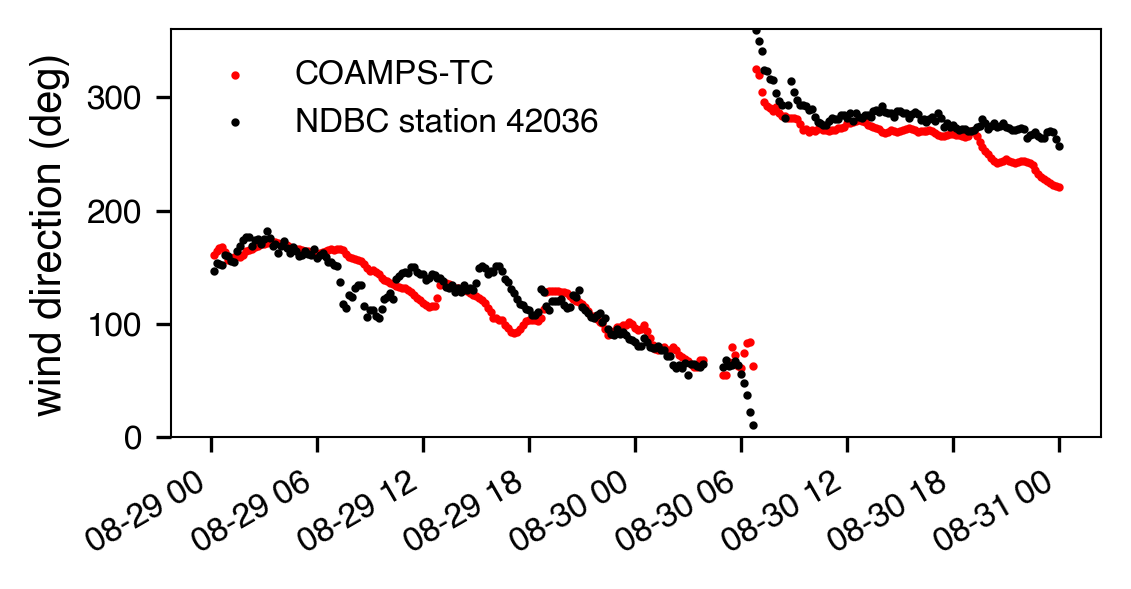

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.scatter(
    coamps_wind_direction['time'],
    coamps_wind_direction,
    color='r',
    s=1,
    label='COAMPS-TC',
)
ax.scatter(
    ndbc_wind_direction['time'],
    ndbc_wind_direction,
    color='k',
    s=1,
    label='NDBC station 42036',
)
ax.set_ylabel('wind direction (deg)')
ax.legend(frameon=False)
ax.set_ylim([0, 360])
fig.autofmt_xdate()

# fig.savefig('revfig-coamps_ndbc_direction_timeseries.png', bbox_inches='tight')

Unwrap directions for error analysis.

In [107]:
ndbc_wind_direction_unwrap = np.unwrap(ndbc_wind_direction, period=360)
coamps_wind_direction_unwrap = np.unwrap(coamps_wind_direction, period=360)

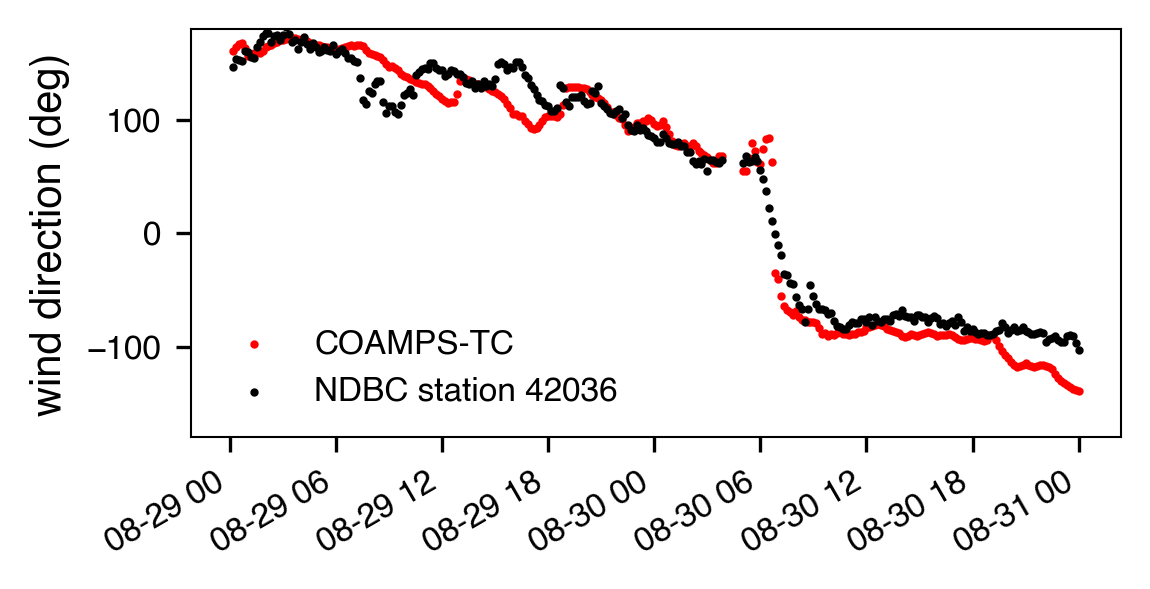

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.scatter(
    coamps_wind_direction['time'],
    coamps_wind_direction_unwrap,
    color='r',
    s=1,
    label='COAMPS-TC',
)
ax.scatter(
    ndbc_wind_direction['time'],
    ndbc_wind_direction_unwrap,
    color='k',
    s=1,
    label='NDBC station 42036',
)
ax.set_ylabel('wind direction (deg)')
ax.legend(frameon=False)
ax.set_ylim([-180, 180])
fig.autofmt_xdate()

In [109]:
direction_error = ndbc_wind_direction_unwrap - coamps_wind_direction_unwrap

print(f'error mean: {direction_error.mean().round(0)} deg')
print(f'error std: {direction_error.std().round(0)} deg')
print(f'# observations: {direction_error.size}')

error mean: 6.0 deg
error std: 19.0 deg
# observations: 282


Plot an error histogram.

Text(0.95, 0.95, '$\\mu$ = 6 deg\n$\\sigma$ = 19 deg')

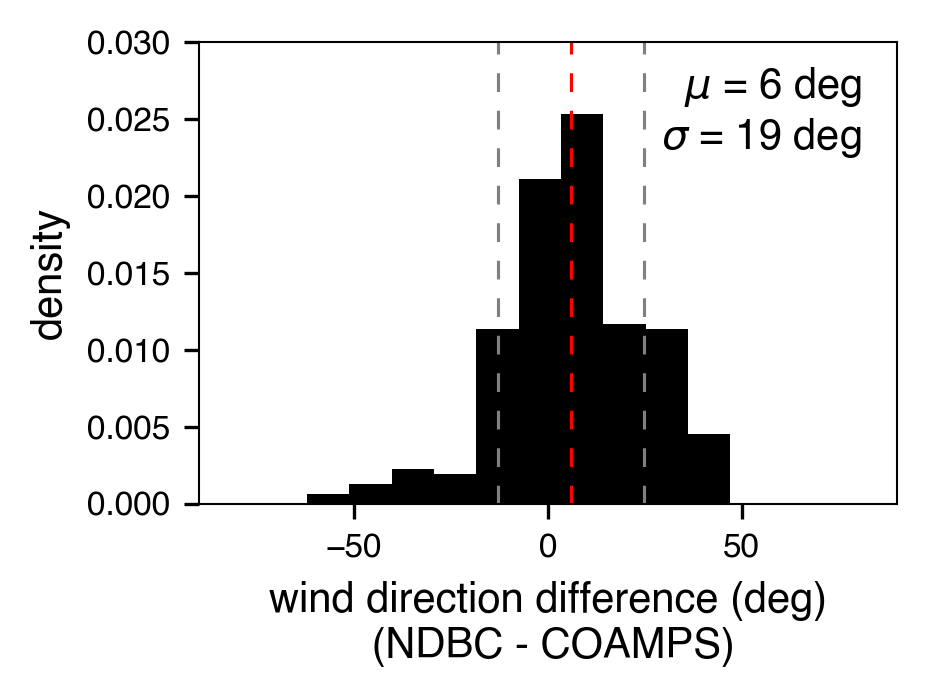

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.hist(direction_error, color='k', density=True, bins=10)
# ax.set_xlabel(r'NDBC $\theta_\mathrm{wind}$ - COAMPS-TC $\theta_\mathrm{wind}$ (deg)', fontsize=plotting.small_font_size)
ax.set_xlabel('wind direction difference (deg)\n (NDBC - COAMPS)')
ax.set_ylabel('density')
ax.set_xlim(90 * np.array([-1, 1]))
ax.set_ylim(0, 0.03)
stat_line_kwargs = {
    'linestyle': '--',
    'linewidth': 0.75,
    'dashes': (6, 6),
}
ax.axvline(direction_error.mean(), color='r', **stat_line_kwargs)
ax.axvline(direction_error.mean() + direction_error.std(), color='grey', **stat_line_kwargs)
ax.axvline(direction_error.mean() - direction_error.std(), color='grey', **stat_line_kwargs)
ax.annotate(r'$\mu$' + f' = {direction_error.mean():0.0f} deg\n'
            r'$\sigma$' + f' = {direction_error.std():0.0f} deg',
             (0.95, 0.95), xycoords='axes fraction', ha='right', va='top')

# fig.savefig('revfig-coamps_direction_error_histogram.png', bbox_inches='tight')

## Store

Store the best fit

In [111]:
%store fit_by_category_df
%store crossing_mss_ratio_bins
%store aligned_mss_ratio_bins

Stored 'fit_by_category_df' (DataFrame)
Stored 'crossing_mss_ratio_bins' (Series)
Stored 'aligned_mss_ratio_bins' (Series)


## References

Holthuijsen, L. H., Powell, M. D., & Pietrzak, J. D. (2012). Wind and waves in extreme hurricanes. J. Geophys. Res., 117(C9), C09003. https://doi.org/10.1029/2012JC007983

